# Example: Masked and weighted average:

This example focuses on area weights (weighting by the area of the grid cell), but is generalizable.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# or
# from imports import (plt, np, xr)
path = '~/shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/tas_Amon_NorESM2-LM_historical_r1i1p1f1_gn_200001-200912.nc'
tas_ds = xr.open_dataset(path)

## Get the area weigts:
For the CMIP data, each model has a file for the area of each grid cell. The variable name of this is 'areacella'. We load the NorESM one.

In [2]:
path_area_weight ='~/shared-cmip6-for-ns1000k/historical/NorESM2-LM/r1i1p1f1/areacella_fx_NorESM2-LM_historical_r1i1p1f1_gn.nc'
areacella= xr.open_dataset(path_area_weight)

## A useful functions to do a weighted and masked average


In [3]:
def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataArray
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average xarray
    """
    #lest make a copy of the xa
    xa_copy:xr.DataArray = xa.copy()

    if mask is not None:
        xa_weighted_average = __weighted_average_with_mask(
            dim, mask, weights, xa, xa_copy
        )
    elif weights is not None:
        xa_weighted_average = __weighted_average(
            dim, weights, xa, xa_copy
        )
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average



    # %% [markdown]


def __weighted_average(dim, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
    x_times_w = xa_copy * weights_all_dims
    xw_sum = x_times_w.sum(dim)
    x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
    xa_weighted_average = xw_sum / x_tot
    return xa_weighted_average


def __weighted_average_with_mask(dim, mask, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, mask_all_dims = xr.broadcast(xa, mask)  # broadcast to all dims
    xa_copy = xa_copy.where(np.logical_not(mask))
    if weights is not None:
        _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
        weights_all_dims = weights_all_dims.where(~mask_all_dims)
        x_times_w = xa_copy * weights_all_dims
        xw_sum = x_times_w.sum(dim=dim)
        x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
        xa_weighted_average = xw_sum / x_tot
    else:
        xa_weighted_average = xa_copy.mean(dim)
    return xa_weighted_average


# ## Application 1: Weigted global average:
# Grid cells have different area, so when we do the global average, they have to be weigted by the area of each grid cell.
# Here we do it for 2 m temperature:

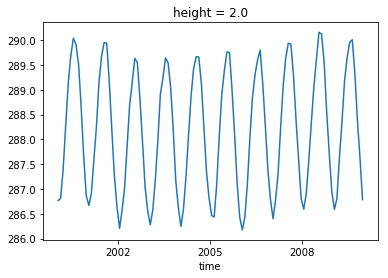

In [4]:
aw_xr = areacella['areacella']
glob_mean = masked_average(tas_ds['tas'], dim=['lat','lon'], weights=aw_xr)
glob_mean.plot()

## Application 1: Weigted arctic average:
Let's try to also take only the data above 60$^\circ$N

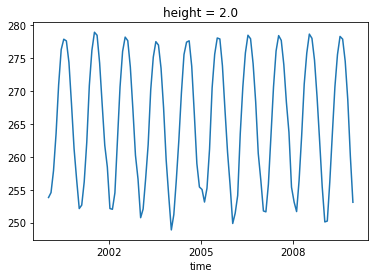

In [5]:
aw_xr = areacella['areacella']
# mask values with lat < 60 deg north
mask = tas_ds['lat']<60.
glob_mean = masked_average(tas_ds['tas'], dim=['lat','lon'], weights=aw_xr, mask=mask)
glob_mean.plot()